In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.0.0'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


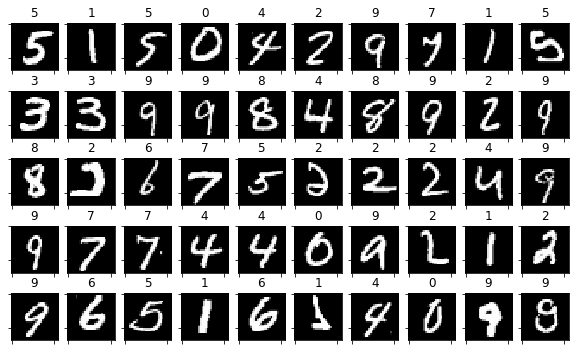

In [3]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder with small (sparse) activations

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [98]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
import tensorflow as tf

given:

- $k=50$, latent dimension
- $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$
- $e(\mathbf{x}^{(i)}) \in \mathbb{R}^{k}$, the encoder
- $d(e(\mathbf{x}^{(i)})) \in \mathbb{R}^{784}$, the decoder

implement the following cost function

$$\text{loss}(\mathbf{x}^{(i)}) = \frac{1}{m}\sum_m \big(\mathbf{x}^{(i)} - d(e(\mathbf{x}^{(i)}))\big)^2 + \beta \frac{1}{k}\sum_{k,i} e(\mathbf{x}^{(i)})$$


In [107]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def get_model(input_dim, code_size, beta=.01):
    inputs = Input(shape=input_dim)
    encoder = Dense(code_size, activation='relu')(inputs)
    outputs = Dense(input_dim, activation='sigmoid')(encoder)

    avg_latent_activations = tf.reduce_mean(encoder, axis=0)
    loss_L2 = tf.reduce_mean(encoder)
    loss_mse = tf.reduce_mean((inputs-outputs)**2)
    loss = loss_mse + beta*loss_L2


    model = Model([inputs], [outputs])    
    model.add_loss(loss)

    model.compile(optimizer='adam')
    return model, encoder, avg_latent_activations

In [108]:
model, encoder, avg_latent_activations = get_model(input_dim=X.shape[1], code_size=50, beta=0.05)

W0220 14:44:45.825977 4384662976 training_utils.py:1444] Output dense_27 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_27.


In [109]:
model.fit(X_train, epochs=100, batch_size=32)

Train on 1200 samples
Epoch 1/100
1200/1200 [==============================] - 0s 171us/sample - loss: 0.2083
Epoch 2/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.1205
Epoch 3/100
1200/1200 [==============================] - 0s 45us/sample - loss: 0.1021
Epoch 4/100
1200/1200 [==============================] - 0s 46us/sample - loss: 0.0931
Epoch 5/100
1200/1200 [==============================] - 0s 46us/sample - loss: 0.0850
Epoch 6/100
1200/1200 [==============================] - 0s 52us/sample - loss: 0.0774
Epoch 7/100
1200/1200 [==============================] - 0s 55us/sample - loss: 0.0709
Epoch 8/100
1200/1200 [==============================] - 0s 54us/sample - loss: 0.0661
Epoch 9/100
1200/1200 [==============================] - 0s 54us/sample - loss: 0.0631
Epoch 10/100
1200/1200 [==============================] - 0s 54us/sample - loss: 0.0608
Epoch 11/100
1200/1200 [==============================] - 0s 48us/sample - loss: 0.0588
Epoch 12/100
1200/

Epoch 94/100
1200/1200 [==============================] - 0s 55us/sample - loss: 0.0352
Epoch 95/100
1200/1200 [==============================] - 0s 55us/sample - loss: 0.0351
Epoch 96/100
1200/1200 [==============================] - 0s 53us/sample - loss: 0.0350
Epoch 97/100
1200/1200 [==============================] - 0s 47us/sample - loss: 0.0349
Epoch 98/100
1200/1200 [==============================] - 0s 45us/sample - loss: 0.0348
Epoch 99/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.0348
Epoch 100/100
1200/1200 [==============================] - 0s 49us/sample - loss: 0.0347


In [118]:
fl = K.function([model.input], [avg_latent_activations])
fl(X_train)

[array([4.4608349e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.8072491e-01, 3.8508105e-01, 4.1526198e-01,
        1.7899944e-03, 0.0000000e+00, 0.0000000e+00, 4.2354482e-01,
        0.0000000e+00, 0.0000000e+00, 3.9055079e-01, 0.0000000e+00,
        3.2591656e-01, 6.4026034e-01, 0.0000000e+00, 4.1022152e-01,
        5.5418462e-01, 6.2894529e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8380924e-01,
        0.0000000e+00, 0.0000000e+00, 3.5680971e-01, 0.0000000e+00,
        0.0000000e+00, 5.9563463e-04, 0.0000000e+00, 4.6177214e-01,
        0.0000000e+00, 5.4042482e-01, 0.0000000e+00, 0.0000000e+00,
        5.9360516e-01, 0.0000000e+00, 4.7642380e-01, 0.0000000e+00,
        5.6514001e-01, 0.0000000e+00, 3.5979575e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32)]

### reconstruction

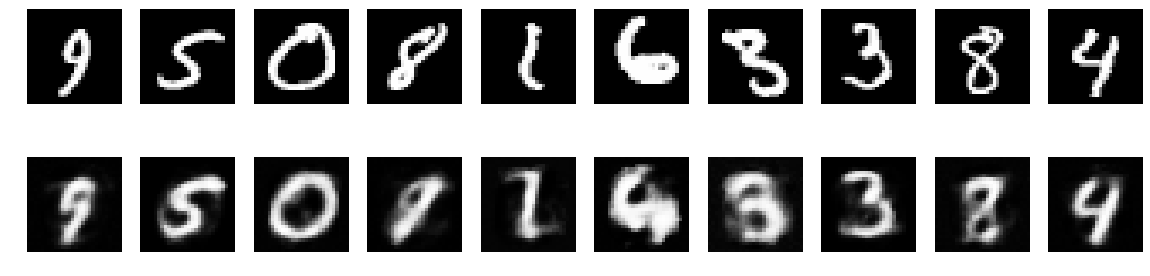

In [111]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### weights

In [112]:
w = model.get_weights()
w[0].shape

(784, 50)

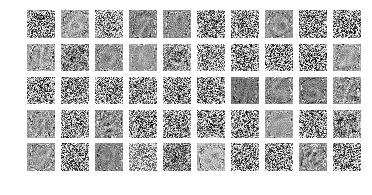

In [113]:
plt.figure(figsize=(6,6))
for k,i in enumerate(np.random.permutation(w[0].shape[1])[:100]):
    plt.subplot(10,10,k+1)
    plt.imshow(w[0][:,i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### activations in latent space

encoded data size (200, 50)
mean activation at encoder 0.169


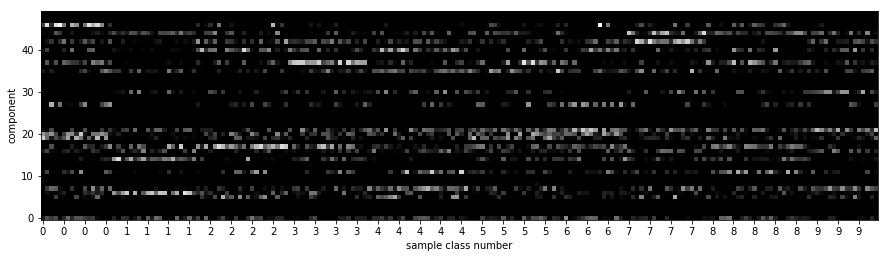

In [114]:
idxs = np.random.permutation(len(X_test))[:200]
idxs = idxs[np.argsort(y_test[idxs])]
y_sample = y_test[idxs]
X_sample = X_test[idxs]

l0_output = K.function([model.input], [encoder])
X_sample_encoded = l0_output([X_sample])[0]
print("encoded data size", X_sample_encoded.shape)
plt.figure(figsize=(15,10))
plt.imshow(X_sample_encoded.T, cmap=plt.cm.Greys_r, origin="bottom")
plt.ylabel("component")
plt.xlabel("sample class number")
plt.xticks(range(len(y_sample))[::5], y_sample[::5]);
print ("mean activation at encoder %.3f"%np.mean(X_sample_encoded))

### observe distribution of activations in latent space

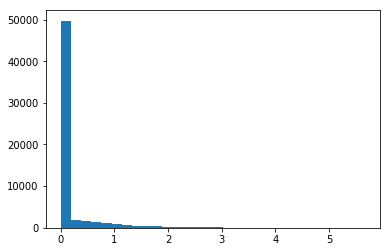

In [115]:
X_sample_encoded = l0_output([X_train])[0]
plt.hist(X_sample_encoded.flatten(), bins=30);

### avg representative of each class in latent space, reconstructed


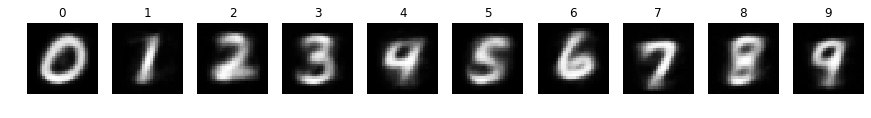

In [116]:
X_train_encoded = l0_output([X_train])[0]

fdecode = K.function([encoder], [model.outputs])
plt.figure(figsize=(15,3))
for k, i in enumerate(np.unique(y_train)):
    plt.subplot(1,10,k+1)
    plt.imshow(fdecode(X_train_encoded[y_train==i].mean(axis=0).reshape(1,-1))[0][0][0].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off"); plt.title("%d"%i);
        

### most representative neuron in latent space for each class


class 0, most avg activated neuron is 46, with value 1.94
class 1, most avg activated neuron is 14, with value 1.65
class 2, most avg activated neuron is 17, with value 1.79
class 3, most avg activated neuron is 37, with value 1.90
class 4, most avg activated neuron is 40, with value 1.07
class 5, most avg activated neuron is 19, with value 1.13
class 6, most avg activated neuron is 21, with value 1.49
class 7, most avg activated neuron is 42, with value 1.62
class 8, most avg activated neuron is 37, with value 0.95
class 9, most avg activated neuron is 44, with value 1.05


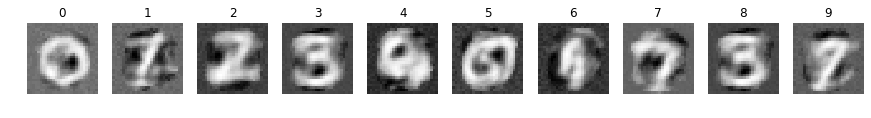

In [117]:
X_train_encoded = l0_output([X_train])[0]
plt.figure(figsize=(15,3))
for k, i in enumerate(np.unique(y_train)):
    plt.subplot(1,10,k+1)
    k = np.zeros(50)
    most_activated_neuron = np.argmax(X_train_encoded[y_train==i].mean(axis=0))
    k[np.argmax(X_train_encoded[y_train==i].mean(axis=0))] = 1
    print ("class %d, most avg activated neuron is %d, with value %.2f"%(i, most_activated_neuron, np.max(X_train_encoded[y_train==i].mean(axis=0))))
    plt.imshow(fdecode(k.reshape(1,-1))[0][0][0].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off"); plt.title("%d"%i);